In [1]:
#"I  certify that the code and data in this assignment were generated independently,
#using only the tools and resources defined in the course and that I (we) did not receive
#any external help, coaching or contributions during the production of this work."

In [2]:
!pip install gym

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

from abc import ABC, abstractmethod

In [4]:
grid = np.zeros((4, 4))
print(grid)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


C:\Users\Soumith\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
pos1 = [3, 0]
pos2 = [0, 3]
battery_1=[0,0]
battery_2=[0,2]
rock_1=[3,2]
rock_2=[2,3]

grid[tuple(pos1)] = 1
grid[tuple(pos2)] = 0.5
grid[tuple(battery_1)] = 0.7
grid[tuple(battery_2)] = 0.7
grid[tuple(rock_1)] = 0.3
grid[tuple(rock_2)] = 0.3

print(grid)

[[0.7 0.  0.7 0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0.3]
 [1.  0.  0.3 0. ]]


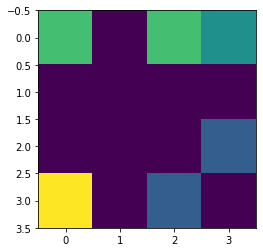

In [6]:
plt.imshow(grid)

In [7]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': []}

    def __init__(self):
        self.observation_space = spaces.Box(0,4,shape=(400,400))
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 15
        #self.visited=[]
    

    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 3]
        self.goal_pos = [3, 0]
        self.battery_1_pos=[0,0]
        self.battery_2_pos=[0,2]
        self.rock_1_pos=[3,2]
        self.rock_2_pos=[2,3]
        self.low=0
        self.high=4
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.battery_1_pos)] = 0.7
        self.state[tuple(self.battery_2_pos)] = 0.7
        self.state[tuple(self.rock_1_pos)] = 0.3
        self.state[tuple(self.rock_2_pos)] = 0.3
        
        self.rewards = {
            tuple(self.battery_1_pos) : 0.5,
            tuple(self.battery_2_pos) : 0.6,
            tuple(self.rock_1_pos) : -0.5,
            tuple(self.rock_2_pos) : -0.6,
        }
        
        observation = self.state.flatten()
        return tuple(self.agent_pos)
    
    def get_index(self, object_pos):
        return object_pos[0] * self.action_space.n + object_pos[1]

    def step(self, action):
    #self.state = np.random.choice(self.observation_space.n)
        flag=0
        '''for i in self.visited:
            print(i)
            if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,self.agent_pos,i), True):
                flag=1
                break'''
        if  flag==0:
            if action == 0:
                self.agent_pos[0] += 1
            elif action == 1 :
                    self.agent_pos[0] -= 1
            elif action == 2 :
                self.agent_pos[1] += 1
            elif action == 3:
                self.agent_pos[1] -= 1
        #print(self.agent_pos)
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        #self.visited.append(self.agent_pos)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.battery_1_pos)] = 0.7
        self.state[tuple(self.battery_2_pos)] = 0.7
        self.state[tuple(self.rock_1_pos)] = 0.3
        self.state[tuple(self.rock_2_pos)] = 0.3
        observation = self.state.flatten()
        done = False
        reward = 0
        
        '''if tuple(self.agent_pos) in self.rewards.keys():
            ## Remove reward once it is claimed
            reward = self.rewards.pop(tuple(self.agent_pos))
            '''
        
        if (self.agent_pos == self.goal_pos).all():
            done = True
            reward = 1
        else:
            reward = -0.01
            
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            done = True
        info = {}

        return tuple(self.agent_pos), reward, done, info

    def render(self):
        plt.imshow(self.state)

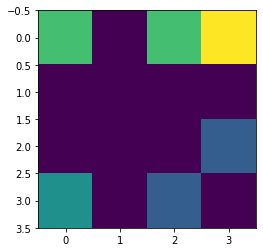

In [8]:
env = GridEnvironment()
obs = env.reset()
env.render()

observation:  (0, 3)
Reward:  -0.01


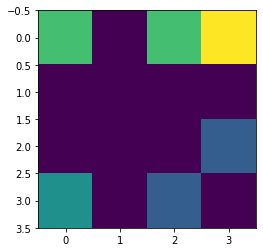

In [9]:
action = 1
observation, reward, done, _ = env.step(action)
env.render()
print('observation: ', observation)
print('Reward: ', reward)

3
Reward:  -0.01
2
Reward:  -0.01
1
Reward:  -0.01
3
Reward:  -0.01
1
Reward:  -0.01
1
Reward:  -0.01
3
Reward:  -0.01
1
Reward:  -0.01
2
Reward:  -0.01
0
Reward:  -0.01


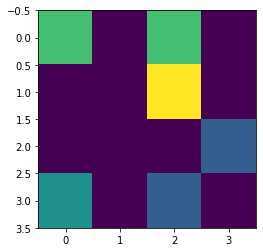

In [10]:
import random
import time
import functools 
for _ in range(10):
    action=random.choice([0,1,2,3])
    print(action)
    observation, reward, done, _ = env.step(action)
    
    env.render()
    print('Reward: ', reward)
   



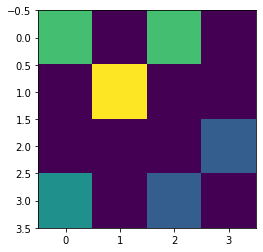

In [11]:
observation, reward, done, _ = env.step(3)
env.render()


In [12]:
class LearningAgent(ABC):
    
    def __init__(self, env, max_iter):
        self.env = env
        self.max_iter = max_iter
        self.min_prob = 0.01
        self.decay_rate = 4/self.max_iter
        
    ## Epsilon decay
    def calculate_eps(self, i):
        return max(self.min_prob, np.exp(-i * self.decay_rate))
        
    @abstractmethod
    def step(self, agent_pos, eps):
        pass
    

In [13]:
class SARSALearningAgent(LearningAgent):
    
    def __init__(self, env, max_iter):
        super().__init__(env, max_iter)
        self.q_val = np.zeros((16,4))
        
    def step(self, agent_pos, eps):
        p = np.random.random()
        if p < eps:
            action = np.random.choice(self.env.action_space.n)
        else:
            action = np.argmax(self.q_val[self.env.get_index(agent_pos)])
        return action
    
    def get_max_iter(self):
        return self.max_iter
    
    def get_q_val(self):
        return self.q_val
    
    # Update Q-matrix
    def update_q_val(self, agent_pos, action, eps, alpha = 0.1, gamma = 1):
        done = False
        rew  = 0
        while not done:
            updt_agent_pos, reward, done, _ = env.step(action)
            i = self.env.get_index(agent_pos) 
            i_updt = self.env.get_index(updt_agent_pos)
            new_action = self.step(updt_agent_pos, eps)
            #print(agent_pos, action, updt_agent_pos, reward, done)
            #print(i, action, i_updt, new_action, done)
            self.q_val[i, action] += alpha * (reward + gamma*self.q_val[i_updt, new_action] - self.q_val[i, action])
            action = new_action
            agent_pos = updt_agent_pos
            rew += reward
        return rew
    
    def get_optimal_action(self, pos):
        return np.argmax(self.q_val[self.env.get_index(pos)])

In [14]:
def train_learning(env, agent, reward_decay):
    total_rewards = []
    eps_decay = []
    for i in range(agent.get_max_iter()):
        agent_pos = env.reset()
        done = False
        eps = agent.calculate_eps(i)
        action = agent.step(agent_pos, eps)
        rew = agent.update_q_val(agent_pos, action, eps, gamma = reward_decay)
        total_rewards.append(rew)
        eps_decay.append(eps)
    return total_rewards, eps_decay

In [15]:
env = GridEnvironment()
    
reward_decay = 0.95
max_iter = 200
agent = SARSALearningAgent(env, max_iter)
rew, eps = train_learning(env, agent, reward_decay)

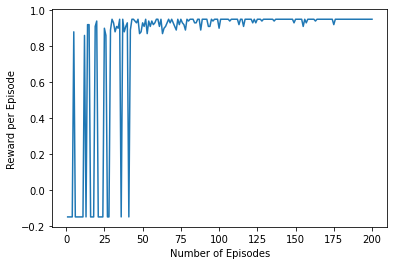

In [16]:
x = np.linspace(1, max_iter, max_iter) 
fig = plt.figure() 
plt.plot(x, rew)
plt.ylabel("Reward per Episode")
plt.xlabel("Number of Episodes")
plt.show()

C:\Users\Soumith\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


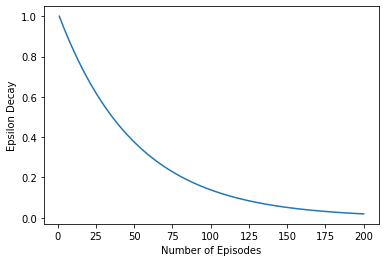

In [17]:
fig = plt.figure() 
plt.plot(x, eps)
plt.ylabel("Epsilon Decay")
plt.xlabel("Number of Episodes")
plt.show()

In [18]:
def use_optimal_learning(env, agent, episodes):    
    rewards = []
    steps = []
    for i in range(episodes):
        agent_pos = env.reset()
        done = False
        episode_reward = 0
        step_count = 0
        while not done:
            optimal_action = agent.get_optimal_action(agent_pos)
            agent_pos, reward, done, _ = env.step(optimal_action)
            episode_reward += reward
            step_count += 1
        rewards.append(episode_reward)
        steps.append(step_count)
    return rewards, steps

C:\Users\Soumith\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


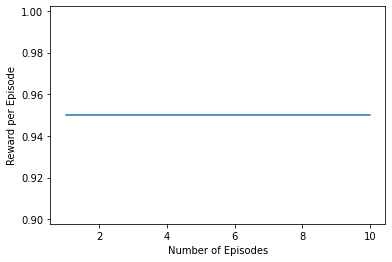

In [19]:
episodes = 10

episode_rewards, steps = use_optimal_learning(env, agent, episodes)

x_episodes = np.linspace(1, episodes, episodes)

fig = plt.figure() 
plt.plot(x_episodes, episode_rewards)
plt.ylabel("Reward per Episode")
plt.xlabel("Number of Episodes")
plt.show()